In [12]:
%pylab inline
import os
import gc
import scipy
import catutil
import numpy as np
import imgSimutil as imgUtil
import astropy.io.fits as pyfits
from astropy.table import Table,vstack,hstack

Populating the interactive namespace from numpy and matplotlib


In [2]:
cd wrkDir/FPFS2/sim/

/lustre/work/xiangchong.li/work/FPFS2/sim


In [3]:
len(imgUtil.cosmoHSThpix)

134

In [54]:
names=['ext_shapeHSM_HsmShapeRegauss_e1','ext_shapeHSM_HsmShapeRegauss_e2','base_SdssShape_x','base_SdssShape_y',\
       'modelfit_CModel_instFlux','modelfit_CModel_instFluxErr','ext_shapeHSM_HsmShapeRegauss_resolution']
pltDir='../../galSim-HSC/s19/s19-1/anaCat_newS19Mask_fdeltacut/plot/optimize_weight/'

pix_scale=  0.168/3600.
cosmo252=   imgUtil.cosmoHSTGal('252')
#for index in range(133):
index   =   0
pixId   =   imgUtil.cosmoHSThpix[index]
dd      =   cosmo252.hpInfo[cosmo252.hpInfo['pix']==pixId]
nx      =   int(dd['dra']/pix_scale)
ny      =   int(dd['ddec']/pix_scale)

hstcat  =   cosmo252.readHpixSample(pixId)
msk     =   (hstcat['xI']>32)&(hstcat['yI']>32)&(hstcat['xI']<nx-32)&(hstcat['yI']<ny-32)
hstcat  =   hstcat[msk]
xyRef   =   np.vstack([hstcat['xI'],hstcat['yI']]).T
tree    =   scipy.spatial.cKDTree(xyRef)
del msk,xyRef
gc.collect()
for ii in range(2):
    inoi=index*(30)+ii
    data=Table.read('outCosmo-var36em4/src-psf60-%d/src%04d-g1-0000.fits' %(pixId,inoi))
    data['a_i']=0.
    wlmsk=catutil.get_wl_flags(data)
    data=data[names][wlmsk]
    xyDat=np.vstack([data['base_SdssShape_x'],data['base_SdssShape_y']]).T
    dis,inds=tree.query(xyDat,k=1)
    matcat=hstcat[inds]
    mask=(dis<=(0.6/0.168))
    data=data[mask]
    matcat=matcat[mask]
    sigmae  =   catutil.get_sigma_e_model(data,pltDir)
    data['i_hsmshaperegauss_derived_sigma_e']=   sigmae
    erms    =   catutil.get_erms_model(data,pltDir)
    data['i_hsmshaperegauss_derived_rms_e']  =   erms
    data['i_hsmshaperegauss_derived_weight'] =   1./(sigmae**2 + erms**2)
    data['mag_auto']=matcat['mag_auto']
    data['zphot']=matcat['zphot']
    data['cosmo_index']=matcat['index']
    del xyDat,dis,inds,mask,wlmsk,matcat
    gc.collect()

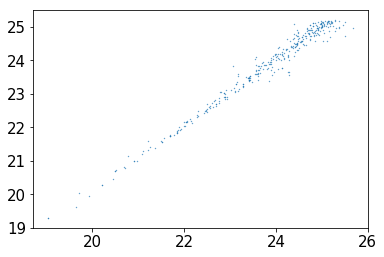

In [17]:
plt.scatter(catutil.get_imag(data),matcat['mag_auto'],s=0.1)

The measured magnitude is brighter than that of the input by: 0.036912815907228655


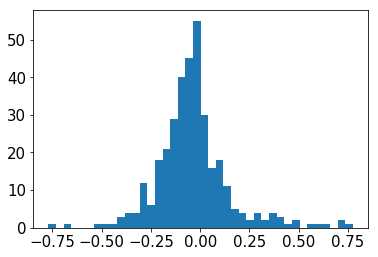

In [21]:
_=plt.hist(catutil.get_imag(data)-matcat['mag_auto'],bins=40)
print('The measured magnitude is brighter than that of the input by:',\
      np.nanmean(matcat['mag_auto']-catutil.get_imag(data)))

## Match distance test

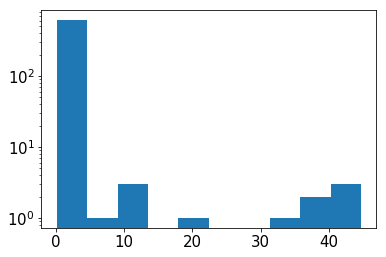

In [26]:
plt.hist(out[0])
plt.yscale('log')

In [27]:
datSelX=data[out[1]]['base_SdssShape_x']
datSelY=data[out[1]]['base_SdssShape_y']
mask=out[0]<5

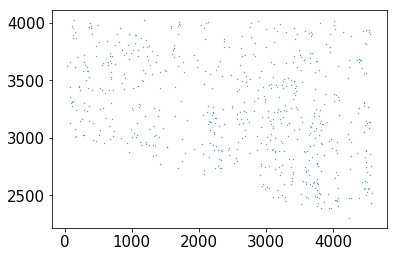

In [42]:
plt.scatter(datSelX[mask],datSelY[mask],s=0.1)

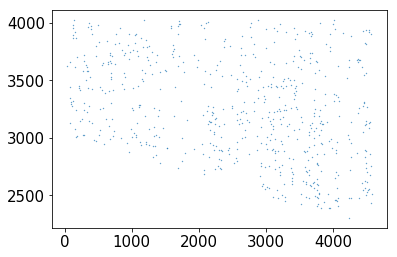

In [43]:
plt.scatter(hscCat['xI'][mask],hscCat['yI'][mask],s=0.1)